In [288]:
import json
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
def load_df(csv_path='train.csv', nrows=None) -> pd.DataFrame:
    """
        JSON 형태로 되어있는 컬럼들을 모아서 DataFrame형태로 바꾸는 함수
        converters : JSON 컬럼들의 값들을 json_loads로 데이터 프레임화 시키는 함수를 적용하는 파라미터
        dtype : 데이터를 불러올 때 fullVisitorId의  dtype을 미리 str로 정의
        nrows :  limit와 같은 존재 너무 크면 오래걸리니까 2만으로 줄임.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    '''
    normalize는 json을 정규화(평평하게)만드는 것이며 이는 중첩된 구조를 하나의 테이블로 펼쳐서, 각각의 요소를 행으로 나타내는 것
    흔히 우리가 아는 테이블의 형태로 나타나게 된다. 
    새로운 컬럼을 for문을 통해서 각 column마다 서브 column name으로 할당
    정규화 되기 전 컬럼은 삭제하고, 새로운 컬럼으로 덮어씌운다.
    '''
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

df_small = load_df(nrows=20000)

In [289]:
df_small.iloc[:,33:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   geoNetwork_longitude                               20000 non-null  object
 1   geoNetwork_networkLocation                         20000 non-null  object
 2   totals_visits                                      20000 non-null  object
 3   totals_hits                                        20000 non-null  object
 4   totals_pageviews                                   20000 non-null  object
 5   totals_bounces                                     10483 non-null  object
 6   totals_newVisits                                   15452 non-null  object
 7   totals_transactionRevenue                          248 non-null    object
 8   trafficSource_campaign                             20000 non-null  object
 9   trafficSource_sou

In [290]:
def change_numeric(x:pd.DataFrame) :
    '''
        결측치를 처리하고 문자열-> int형으로 형변환하는 함수
    '''
    COLUMNS = ['totals_newVisits']
    for columns in COLUMNS:
        x[columns]=x[columns].notnull().astype(int)
    return x
    
df_small=change_numeric(df_small)
df_small.totals_newVisits.unique()


array([1, 0])

In [291]:
df_small['visitStartTime']=pd.to_datetime(df_small['visitStartTime'],unit='s')
df_small['visitStartTime']

0       2016-09-02 15:33:05
1       2016-09-03 05:22:27
2       2016-09-03 01:16:26
3       2016-09-03 05:40:13
4       2016-09-02 13:23:20
                ...        
19995   2016-11-18 19:55:46
19996   2016-11-18 16:21:45
19997   2016-11-19 02:26:39
19998   2016-11-18 11:21:47
19999   2016-11-19 03:17:05
Name: visitStartTime, Length: 20000, dtype: datetime64[ns]

<Axes: xlabel='totals_bounces'>

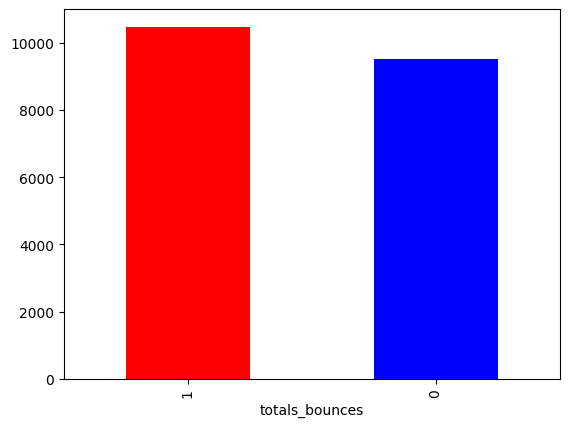

In [292]:
# df_small['totals_bounces'].apply(lambda x: type(x)) -> bounces는 str로 이루어진 데이터 
# int로 바꾸면 1,0으로 이루어진 데이터임을 unique를 통해 알 수 있다. 
df_small['totals_bounces']=df_small['totals_bounces'].notnull().astype(int)
df_small['totals_bounces'].value_counts().plot.bar(color=['red','blue'])

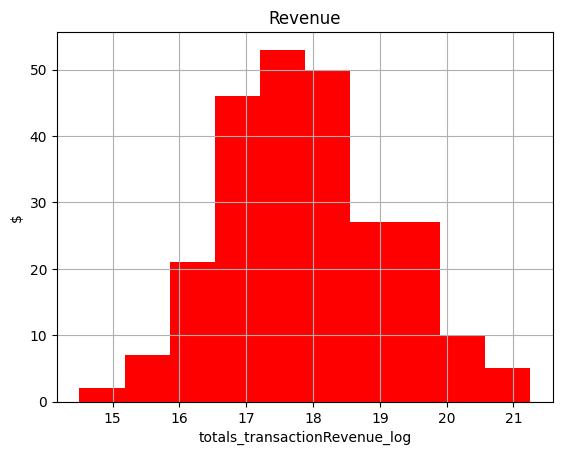

In [293]:
# not null인 데이터가 248개 (0.0124%)만 존재해서 이걸 활용하기엔 데이터의 수가 적어보임
df_notnull = df_small[df_small['totals_transactionRevenue'].notnull()]
df_small['totals_transactionRevenue']= df_notnull['totals_transactionRevenue'].astype(int)
df_small['totals_transactionRevenue_log']=np.log1p(df_small['totals_transactionRevenue'])

df_small['totals_transactionRevenue_log'].hist(color='red')
plt.xlabel('totals_transactionRevenue_log')
plt.ylabel('$')
plt.title('Revenue')
plt.show()


In [294]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 55 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   channelGrouping                                    20000 non-null  object        
 1   date                                               20000 non-null  int64         
 2   fullVisitorId                                      20000 non-null  object        
 3   sessionId                                          20000 non-null  object        
 4   socialEngagementType                               20000 non-null  object        
 5   visitId                                            20000 non-null  int64         
 6   visitNumber                                        20000 non-null  int64         
 7   visitStartTime                                     20000 non-null  datetime64[ns]
 8   device_browser  

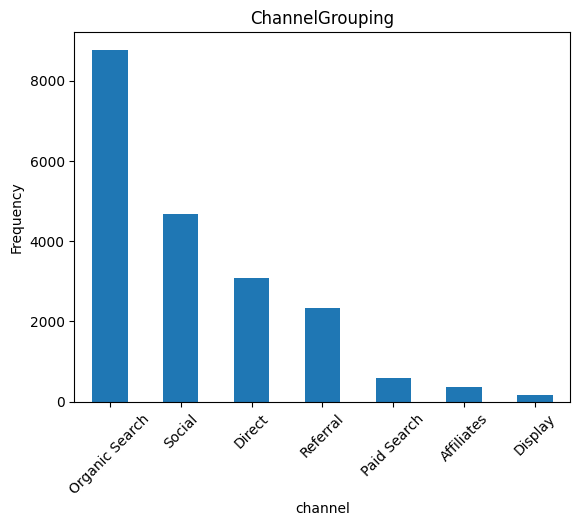

In [295]:
df_small.channelGrouping.value_counts().plot.bar()
plt.xlabel('channel')
plt.ylabel('Frequency')
plt.title('ChannelGrouping')
plt.xticks(rotation=45)
plt.show()

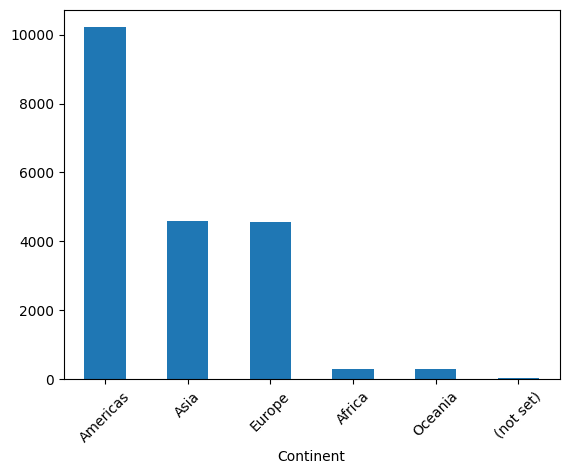

In [296]:
df_small.geoNetwork_continent.value_counts().plot.bar()
plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.show()

In [297]:
df_small.trafficSource_source.value_counts()

trafficSource_source
google                   9259
youtube.com              4484
(direct)                 3090
mall.googleplex.com      1521
Partners                  371
                         ... 
aol                         1
images.google               1
google.gatewaycdi.com       1
google.pl                   1
search.xfinity.com          1
Name: count, Length: 87, dtype: int64

In [300]:
result_df = df_small.groupby(df_small['channelGrouping'])['trafficSource_source'].value_counts().sort_values(ascending=False)
result_df

channelGrouping  trafficSource_source
Organic Search   google                  8650
Social           youtube.com             4484
Direct           (direct)                3090
Referral         mall.googleplex.com     1521
Paid Search      google                   595
                                         ... 
Referral         google.pl                  1
                 google.ru                  1
                 gophergala.com             1
                 gsuite.google.com          1
Social           plus.google.com            1
Name: count, Length: 89, dtype: int64

In [299]:
df_small['visitStartTime'].groupby(df_small['visitId']).count()

visitId
1470895819    1
1470898794    1
1470898819    1
1470898856    1
1470898928    1
             ..
1498287422    1
1498287439    1
1498287546    1
1498287583    1
1498287587    1
Name: visitStartTime, Length: 19668, dtype: int64